<a href="https://colab.research.google.com/github/Noam2710/StyleGAN_Interpolation/blob/master/Copy_of_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [0]:
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
from matplotlib import pyplot as plt
import pickle
list_of_models = ['vgg16']
model_to_color = {'vgg16':'b','resnet50':'r','senet50':'g'}
list_of_algo = ['OpenAI']
algo_to_color = {'OpenAI':'b','CMA-ES':'r','RandomSearch':'g'}
fps_in_video = 5
image_size_in_video = (600,600)
es_learning_rate = 0.1
rnd = np.random.RandomState(seed=5)

In [0]:
tflib.init_tf()
with open('/content/drive/My Drive/karras2019stylegan-ffhq-1024x1024.pkl', "rb") as f:
  _G, _D, Gs = pickle.load(f)











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Source image


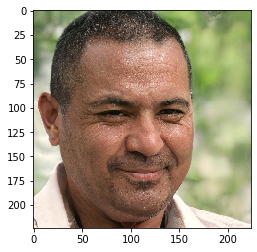

Destination image


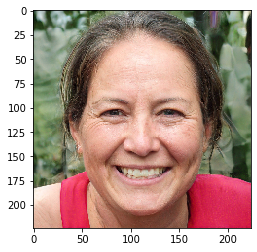

In [0]:
latents = rnd.randn(2, Gs.input_shape[1])
dest_latent = latents[1,np.newaxis]
source_latent = latents[0,np.newaxis]
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
source_image = np.squeeze(Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
dest_image = np.squeeze(Gs.run(dest_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
print("Source image")
source_res = cv2.resize(np.squeeze(source_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(source_res)
plt.show()
print("Destination image")
dest_res = cv2.resize(np.squeeze(dest_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(dest_res)
plt.show()

In [0]:
!pip install evostra
from evostra import EvolutionStrategy

  Created wheel for evostra: filename=evostra-2.5.2-py2.py3-none-any.whl size=5628 sha256=349e31341a67b292106be3f178cadd7fef173be942b0f22a653861ac632a89cd
  Stored in directory: /root/.cache/pip/wheels/8a/d2/0a/19e1279290da14ce7c3d25589e21f264037ac9fb38ae18aa55
Successfully built evostra


In [0]:
pip install keras_vggface

In [0]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from datetime import datetime

def predict_features_from_image(res):
  res = image.img_to_array(res)
  res = np.expand_dims(res, axis=0)
  res = utils.preprocess_input(res, version=2) # or version=2
  return vgg_features.predict(res)

Using TensorFlow backend.


In [0]:
def get_reward_by_vgg(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return -np.linalg.norm(image_to_check_features - features_of_dest_images)

def get_rewared_by_vgg_cosine(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return cosine_similarity(np.squeeze(image_to_check_features),np.squeeze(features_of_dest_images))*50

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [0]:
def run_es_model(verbose=False,run_each_time=2,total_runs=600):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_vectors = []
  list_of_rewards = []
  es = EvolutionStrategy(init_latent_vector, get_reward_by_vgg, population_size=50, sigma=0.5, learning_rate=es_learning_rate, num_threads=1)
  for i in range (int(total_runs/run_each_time)):
    print("Iterations {} - {} | Reward {}".format(i*run_each_time,(i+1)*run_each_time,es.get_reward(es.get_weights())))
    es.run(run_each_time,print_step=run_each_time*10000)
    list_of_rewards.append(es.get_reward(es.get_weights()))
    list_of_vectors.append(np.squeeze(es.get_weights()[0]))
    images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    res = cv2.resize(np.squeeze(images), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return list_of_images,list_of_vectors,list_of_rewards

In [0]:
def export_list_to_pickle(network_name):
  for algo in list_of_algo:
    with open('./logs/{}--{}.pkl'.format(algo,es_learning_rate), 'wb') as f:
      pickle.dump(model_to_rewards[network_name][algo], f)

def print_graphs_for_feature_extraction_network(network_name):
  for algo in list_of_algo:
    plt.plot(list(range(1,len(model_to_rewards[network_name][algo])+1)),model_to_rewards[network_name][algo], algo_to_color[algo], label=algo)
  plt.title(network_name)
  plt.legend()
  plt.show()

In [0]:
def list_of_images_to_video(image_list,model_name,algo,date_time):  
  out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), fps_in_video, image_size_in_video)
  for i in range(len(images_list)):
      out.write(images_list[i])
  out.release()

  !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
  os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}--{}.avi'.format(model_name,algo,date_time))

In [26]:
global es_learning_rate
for lr in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
  es_learning_rate = lr
  model_to_rewards = {}
  features_of_dest_images = None
  for model in list_of_models:
    model_to_rewards[model] = {}
    for algo in list_of_algo:
      now = datetime.now() # current date and time
      date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
      vgg_features = VGGFace(model=model, include_top=False, input_shape=(224, 224, 3), pooling='avg')
      if algo == 'OpenAI':
        images_list,vectors_list,reward_list = run_es_model(verbose=False,run_each_time=2,total_runs=600)

      list_of_images_to_video(images_list,model,algo,date_time)
      model_to_rewards[model][algo] = reward_list

    export_list_to_pickle(model)

Iterations 0 - 2 | Reward -108.50304412841797
Iterations 2 - 4 | Reward -107.60635375976562
Iterations 4 - 6 | Reward -107.07794952392578
Iterations 6 - 8 | Reward -106.62152099609375
Iterations 8 - 10 | Reward -106.17814636230469
Iterations 10 - 12 | Reward -105.88623046875
Iterations 12 - 14 | Reward -105.8084487915039
Iterations 14 - 16 | Reward -105.46595001220703
Iterations 16 - 18 | Reward -105.20174407958984
Iterations 18 - 20 | Reward -104.91232299804688
Iterations 20 - 22 | Reward -104.82948303222656
Iterations 22 - 24 | Reward -104.46804809570312
Iterations 24 - 26 | Reward -104.20198822021484
Iterations 26 - 28 | Reward -103.7773666381836
Iterations 28 - 30 | Reward -103.3927001953125
Iterations 30 - 32 | Reward -103.02058410644531
Iterations 32 - 34 | Reward -102.64044189453125
Iterations 34 - 36 | Reward -102.37606811523438
Iterations 36 - 38 | Reward -102.09130859375
Iterations 38 - 40 | Reward -101.82821655273438
Iterations 40 - 42 | Reward -101.24271392822266
Iterations

In [0]:
!mv  './logs' '/content/drive/My Drive'